In [1]:
#!pip install ib_insync
#!pip install bs4
from ib_insync import *
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import quantstats as qs

In [3]:
util.startLoop()
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=100)

<IB connected to 127.0.0.1:7497 clientId=100>

Peer closed connection.


In [4]:
ib.run()

In [5]:
def extract_info(accounts, tag):
    for acc in accounts:
        if tag == acc.tag:
            return acc.value
    return None

In [6]:
account = ib.accountSummary()
print("Net worth:", extract_info(account, "NetLiquidation"))
print("Cash:", extract_info(account, "TotalCashValue"))

Net worth: 1049658.44
Cash: 1041170.29


In [28]:
stock = Stock('MSFT', 'SMART', 'USD', primaryExchange='NASDAQ')
# stock = Crypto('BTC', 'Paxos', 'USD')
bars = ib.reqHistoricalData(stock, endDateTime = '', durationStr = '1 W', barSizeSetting = '3 mins', whatToShow = 'ADJUSTED_LAST', useRTH = False, formatDate = 2)

In [29]:
print(stock)

Stock(symbol='MSFT', exchange='SMART', primaryExchange='NASDAQ', currency='USD')


In [30]:
ib.qualifyContracts(stock)

[Stock(conId=272093, symbol='MSFT', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='MSFT', tradingClass='NMS')]

In [31]:
dfBars = util.df(bars)
# dfBars = dfBars.set_index('date')
dfBars

,date,open,high,low,close,volume,average,barCount
0,2024-06-03 08:00:00+00:00,416.50,416.50,416.00,416.00,1907.0,416.210,7
1,2024-06-03 08:03:00+00:00,416.00,416.40,416.00,416.40,458.0,416.087,3
2,2024-06-03 08:06:00+00:00,416.49,416.49,416.35,416.35,200.0,416.420,2
3,2024-06-03 08:09:00+00:00,416.35,416.35,416.35,416.35,0.0,416.350,0
4,2024-06-03 08:12:00+00:00,416.35,416.35,416.35,416.35,0.0,416.350,0
...,...,...,...,...,...,...,...,...
1406,2024-06-07 15:24:00+00:00,424.63,424.95,424.61,424.87,3834.0,424.720,26
1407,2024-06-07 15:27:00+00:00,424.86,425.01,424.77,425.00,4972.0,424.887,25
1408,2024-06-07 15:30:00+00:00,425.00,425.43,425.00,425.43,6333.0,425.263,44
1409,2024-06-07 15:33:00+00:00,425.45,425.51,425.15,425.16,7040.0,425.433,40


In [11]:
import typing
import pandas as pd
import numpy as np
import numpy.typing as npt
from utils import load_financial_data
from markov import *
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import AdamW
from models import *
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
from utils import load_financial_data, plot_ts, plot_multi_ts

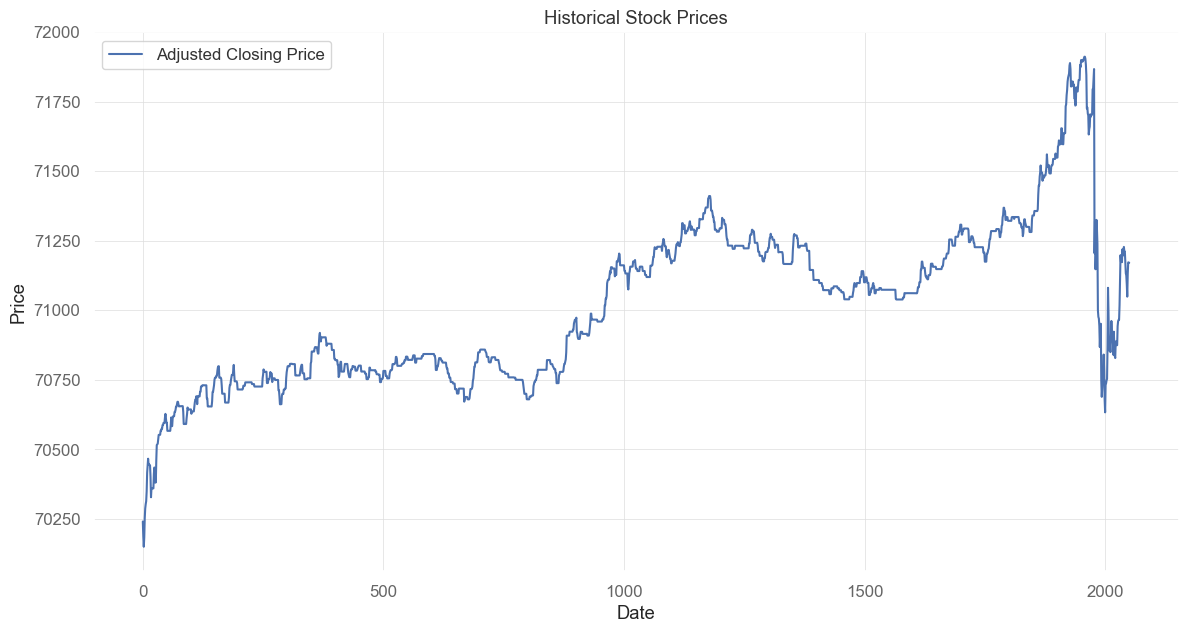

In [13]:
plot_ts(
    data=dfBars["close"], 
    title=f"Historical Stock Prices",
    label_ts="Adjusted Closing Price",
    x_label="Date",
    y_label="Price",
)

In [14]:
security_data = dfBars

In [15]:
from ml import *

In [16]:
markovian_strategy = MLStrategy(
        price=security_data["close"],
        valid_data=security_data["close"],
        test_data=security_data["close"],
        threshold_to_buy=8,
        threshold_to_sell=8,
        lookback=10,
        forward=4,
    )

markovian_strategy.train(
    epochs=100,
    lr=1e-3,
)

100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


In [18]:
markovian_performance = markovian_strategy.backtest(
    initial_cash=1e6,
    num_share_per_trade=1,
    limit_borrow=0,
    limit_num_shorts=0,
    allin=False,
    halfin=False,
)
markovian_performance

100%|██████████| 2042/2042 [00:01<00:00, 1171.56it/s]


,price,daily_return,signals,cash,positions,wealth
0,70241.00,1.000000,0,1000000.00,0.0,1000000.00
1,70186.50,-0.000776,0,1000000.00,0.0,1000000.00
2,70150.25,-0.000516,0,1000000.00,0.0,1000000.00
3,70183.75,0.000478,0,1000000.00,0.0,1000000.00
4,70253.00,0.000987,0,1000000.00,0.0,1000000.00
...,...,...,...,...,...,...
2046,71049.50,-0.000622,1,159472.50,852594.0,1012066.50
2047,71132.50,0.001168,1,88340.00,924722.5,1013062.50
2048,71172.75,0.000566,1,17167.25,996418.5,1013585.75
2049,71171.25,-0.000021,0,17167.25,996397.5,1013564.75


In [19]:
import matplotlib.pyplot as plt

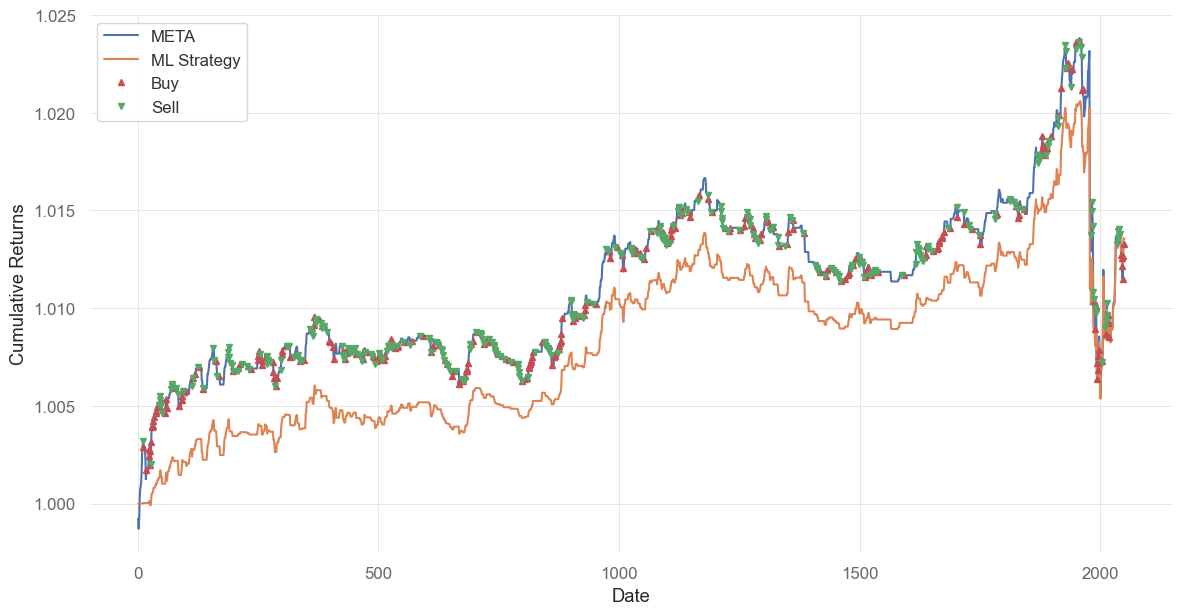

In [20]:
price = security_data["close"]
# price = security_data["Adj Close"]

# Plot both cumulative returns on the same chart 
plt.figure(figsize=(14, 7)) 
plt.plot(price.index, (1 + price.pct_change()).cumprod(), label="META") 
plt.plot(markovian_performance.index, (1 + markovian_performance.wealth.pct_change()).cumprod(), label='ML Strategy')

plt.plot(markovian_performance.loc[markovian_performance.signals == 1.0].index, (1 + price.pct_change()).cumprod()[markovian_performance.signals == 1.0], '^', markersize=5, color='r', label="Buy")
plt.plot(markovian_performance.loc[markovian_performance.signals == -1.0].index, (1 + price.pct_change()).cumprod()[markovian_performance.signals == -1.0], 'v', markersize=5, color='g', label="Sell")


plt.xlabel('Date') 
plt.ylabel('Cumulative Returns') 
plt.legend() 
plt.show()

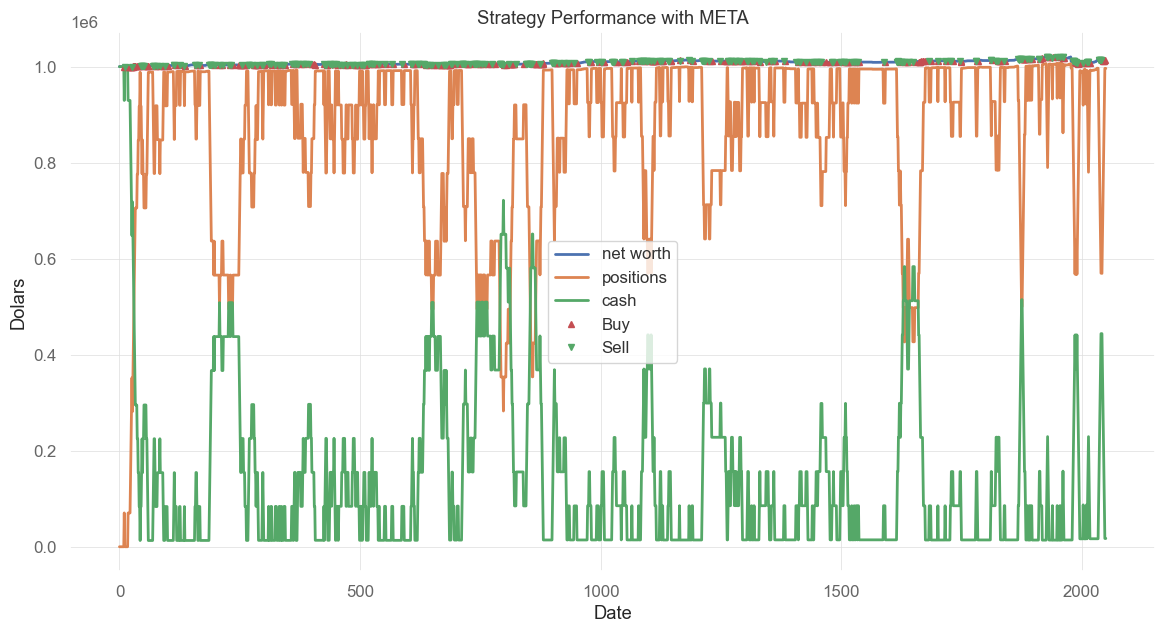

In [21]:
buy_and_hold = price

fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(111, ylabel = 'Price in USD')
markovian_performance.wealth.plot(ax=ax1, lw=2., label="net worth")
markovian_performance.positions.plot(ax=ax1, lw=2., label="positions")
markovian_performance.cash.plot(ax=ax1, lw=2., label="cash")

ax1.plot(markovian_performance.loc[markovian_performance.signals == 1.0].index, markovian_performance.wealth[markovian_performance.signals == 1.0], '^', markersize=5, color='r', label="Buy")
ax1.plot(markovian_performance.loc[markovian_performance.signals == -1.0].index, markovian_performance.wealth[markovian_performance.signals == -1.0], 'v', markersize=5, color='g', label="Sell")

plt.xlabel("Date")
plt.ylabel("Dolars")
plt.title(f"Strategy Performance with META")
plt.legend()
plt.show()

In [20]:
ib.sleep(0)
# Use this code to update the transmitted information

True

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
import datetime
datetime.datetime.now().time() >= datetime.time(4, 50)
datetime.datetime.now().time() >= datetime.time(0, 43)

True

In [38]:
order = MarketOrder("Buy", 0.0001, tif='IOC')
trade = ib.placeOrder(stock, order)
trade

Trade(contract=Crypto(conId=479624278, symbol='BTC', exchange='PAXOS', currency='USD', localSymbol='BTC.USD', tradingClass='BTC'), order=MarketOrder(orderId=610, clientId=1, action='Buy', totalQuantity=0.0001, tif='IOC'), orderStatus=OrderStatus(orderId=610, status='PendingSubmit', filled=0.0, remaining=0.0, avgFillPrice=0.0, permId=0, parentId=0, lastFillPrice=0.0, clientId=0, whyHeld='', mktCapPrice=0.0), fills=[], log=[TradeLogEntry(time=datetime.datetime(2024, 6, 7, 13, 26, 30, 494558, tzinfo=datetime.timezone.utc), status='PendingSubmit', message='', errorCode=0)], advancedError='')

In [23]:
ib.disconnect()
markovian_performance = markovian_strategy.deploy(
    ticker="META",
    initial_cash=1e3,
    num_share_per_trade=1,
    limit_borrow=0,
    limit_num_shorts=0,
    allin=False,
    halfin=False,
)
markovian_performance

2024-05-29 01:31:22.251844 Sell
Garthering data for 5 seconds
2024-05-29 01:31:28.351683 Sell
Garthering data for 5 seconds
2024-05-29 01:31:34.181354 Sell
Garthering data for 5 seconds
2024-05-29 01:31:40.017087 Sell
Garthering data for 5 seconds
2024-05-29 01:31:45.849438 Sell
Garthering data for 5 seconds
2024-05-29 01:31:51.850461 No position
Garthering data for 5 seconds
2024-05-29 01:31:57.701098 No position
Garthering data for 5 seconds
2024-05-29 01:32:03.536202 No position
Garthering data for 5 seconds
2024-05-29 01:32:09.545518 No position
Garthering data for 5 seconds
2024-05-29 01:32:15.489899 No position
Garthering data for 5 seconds
2024-05-29 01:32:21.426972 No position
Garthering data for 5 seconds
2024-05-29 01:32:27.253703 No position
Garthering data for 5 seconds
2024-05-29 01:32:45.167239 No position
Garthering data for 5 seconds
2024-05-29 01:33:03.377138 Sell
Garthering data for 5 seconds
2024-05-29 01:33:09.219659 Sell
Garthering data for 5 seconds
2024-05-29 01:

Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.


2024-05-29 01:35:09.012534 No position
Garthering data for 5 seconds


Error 1102, reqId -1: Connectivity between IBKR and Trader Workstation has been restored - data maintained. All data farms are connected: uscrypto; usfarm.nj; cashfarm; usfarm; fundfarm; ushmds; secdefil.


2024-05-29 01:35:54.691405 No position
Garthering data for 5 seconds
2024-05-29 01:36:01.661645 No position
Garthering data for 5 seconds
2024-05-29 01:36:07.474974 No position
Garthering data for 5 seconds
2024-05-29 01:36:15.310672 No position
Garthering data for 5 seconds
2024-05-29 01:36:21.455852 No position
Garthering data for 5 seconds
2024-05-29 01:36:27.292743 No position
Garthering data for 5 seconds
2024-05-29 01:36:33.114239 No position
Garthering data for 5 seconds
2024-05-29 01:36:56.155264 No position
Garthering data for 5 seconds
2024-05-29 01:37:02.155210 Sell
Garthering data for 5 seconds
2024-05-29 01:37:08.163926 Sell
Garthering data for 5 seconds
2024-05-29 01:37:14.166817 Sell
Garthering data for 5 seconds
2024-05-29 01:37:23.226744 Sell
Garthering data for 5 seconds
2024-05-29 01:37:32.954546 No position
Garthering data for 5 seconds
2024-05-29 01:37:39.161373 No position
Garthering data for 5 seconds
2024-05-29 01:37:45.667402 No position
Garthering data for 5 s

reqHistoricalData: Timeout for Stock(symbol='META', exchange='SMART', currency='USD')


TypeError: 'NoneType' object is not subscriptable

Error 366, reqId 346: No historical data query found for ticker id:346, contract: Stock(symbol='META', exchange='SMART', currency='USD')
Peer closed connection.


In [24]:
markovian_performance.to_csv("result-META.csv")